There is more documentation in here: http://smtn-002.lsst.io/en/latest/ and here: https://docushare.lsstcorp.org/docushare/dsweb/Get/LSE-40

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
import astropy.table
import astropy.io.fits as fits

In [4]:
from scipy.stats import binned_statistic

The 5-$\sigma$ median depth for point sources is computed as the magnitude from a flat SED in a Gaussian aperture that yields an $SNR=5$. We tried two different approaches: One is to analyze the median magnitude of the galaxies where $\sigma_{iso} \geq 5$. The other approach is to simulate stars and check which magnitude corresponds to a median $SNR=5$. We proceed using `scipy.stats.binned_statistic` and choosing the bin where the median $SNR$ is closest to 5. 

In [51]:
def calculate_depth(band,make_plot=False, exptime=6900., X=1.2, mode='Ivezic', snr_name='snr_iso', make_plot2=False, make_plot3=True):
    #Values from Ivezic 2014
    if mode=='Ivezic':
        msky = {'u':22.9, 'g':22.3, 'r':21.2, 'i':20.5, 'z':19.6, 'y':18.6}
        cm = {'u':22.92 , 'g':24.29, 'r':24.33, 'i':24.20, 'z':24.07, 'y':23.69} 
        psf = {'u':0.77 , 'g':0.73, 'r':0.70, 'i':0.67, 'z':0.65, 'y':0.63} 
        inst_noise_corr = {'u':0.67 , 'g':0.21, 'r':0.11, 'i':0.08, 'z':0.05, 'y':0.04}
        km = {'u':0.451,'g':0.163,'r':0.087,'i':0.065,'z':0.043,'y':0.138}
    ####################
    #Values from https://github.com/lsst-pst/syseng_throughputs/blob/master/plots/table2
    if mode=='Sys_eng':
        psf = {'u':0.92 , 'g':0.87, 'r':0.83, 'i':0.80, 'z':0.78, 'y':0.76} 
        cm = {'u':22.74, 'g':24.38, 'r':24.43, 'i':24.30 , 'z':24.15, 'y':23.70}
        msky = {'u':22.95, 'g':22.24, 'r':21.20, 'i':20.47, 'z':19.60, 'y':18.63}
        inst_noise_corr = {'u':0.75 , 'g':0.19, 'r':0.10, 'i':0.07, 'z':0.05, 'y':0.04}
        km = {'u':0.5041,'g':0.2097,'r':0.1263,'i':0.0962,'z':0.0685,'y':0.1760}
    
    exptime_corr = {'u':0.,'g':0.,'r':0,'i':0,'z':0,'y':0} #This is going to be the electronic noise correction placeholder
    exptime_corr[band] = inst_noise_corr[band]-1.25*np.log10(1+(10**(0.8*inst_noise_corr[band])-1)/(exptime/30.))
    fid_depth = cm[band]+0.5*(msky[band]-21.)+2.5*np.log10(0.7/(psf[band]*X**0.6))-km[band]*(X-1)+1.25*np.log10(exptime/30.)+exptime_corr[band]
    colors = {'u':'violet','g':'blue','r':'green','i':'yellow','z':'orange','y':'red'}
    source_table = astropy.table.Table.read('./WeakLensingDeblending/LSST_%s_stars_4096_4096.fits' %(band))
    if make_plot:
        plt.hist(source_table['ab_mag'][source_table[snr_name]>5.],alpha=0.5,label='%s-band' %band, color=colors[band])
        plt.plot(fid_depth*np.ones_like(np.arange(0,250,50)),np.arange(0,250,50),color=colors[band])
        plt.xlabel('mag$_{AB}$')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        #plt.xlim(17,28.5)
    maxdepth = np.nanmax(source_table['ab_mag'][source_table[snr_name]>=5.])
    mediandepth = np.nanmedian(source_table['ab_mag'][source_table[snr_name]>=5.])
    meandepth = np.nanmean(source_table['ab_mag'][source_table[snr_name]>=5.])
    mad = np.nanmedian(np.fabs(source_table['ab_mag'][source_table[snr_name]>=5.]-mediandepth))
    median_snr, bin_edges, binnumber = binned_statistic(source_table['ab_mag'],source_table['snr_iso'],statistic='median',bins=50,range=[(22,30)])
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    mask = np.isnan(median_snr)==False
    median_snr = median_snr[mask]
    bin_centers = bin_centers[mask]
    depth = bin_centers[np.argmin(np.fabs(median_snr-5))]
    delta_depth = bin_centers[4]-bin_centers[3]
    print 'Band: ',band, 'median 5-sigma depth = ', depth, '+-', delta_depth, ' Fiducial value = %.2f' % fid_depth
    print 'Band: ',band, 'max 5-sigma depth= ', maxdepth
    if make_plot2:
        plt.figure()
        mask2 = np.logical_and(source_table['ab_mag']>=depth-delta_depth,source_table['ab_mag']<=depth+delta_depth)
        plt.hist(source_table['snr_iso'][mask2],range=(0,10),color=colors[band],label='%s-band' %band, alpha=0.5)
        plt.xlabel('SNR')
        plt.ylabel('Number of galaxies')
        plt.legend(loc='best')
    if make_plot3:
        plt.figure()
        plt.hist2d(source_table['ab_mag'],source_table['snr_iso'],range=[(22,30),(0,10)],bins=30)
        plt.plot(np.linspace(22,30,5),5*np.ones(5),'r--')
        plt.xlabel('mag$_{AB}$')
        plt.ylabel('SNR')
        plt.colorbar(label='Number of galaxies')
        plt.grid()
    return maxdepth, mediandepth

Band:  u median 5-sigma depth =  27.04 +- 0.16  Fiducial value = 23.77
Band:  u max 5-sigma depth=  27.1085
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value = 24.89
Band:  g max 5-sigma depth=  27.8098
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value = 24.43
Band:  r max 5-sigma depth=  27.2179
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value = 24.00
Band:  i max 5-sigma depth=  26.742
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value = 23.45
Band:  z max 5-sigma depth=  26.0962
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value = 22.60
Band:  y max 5-sigma depth=  25.1892


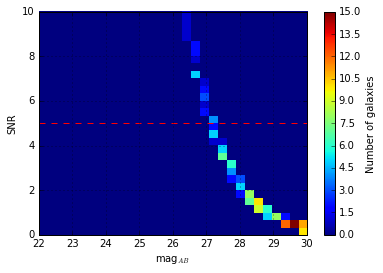

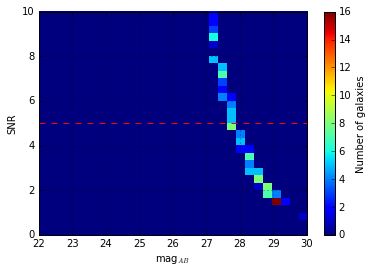

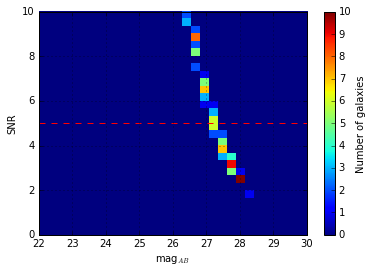

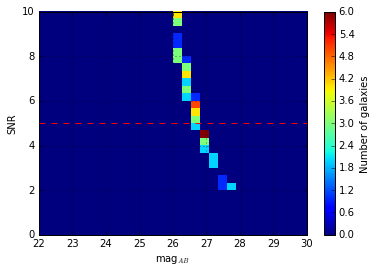

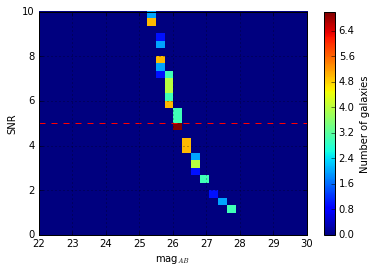

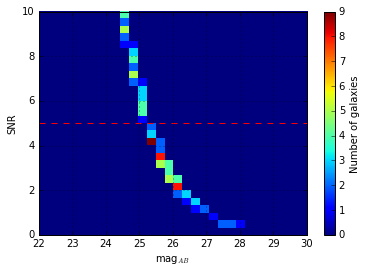

In [52]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, mode='Ivezic', exptime=30, X=1.0)

In [286]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, mode='Sys_eng', exptime=30, X=1.0)

Band:  u median 5-sigma depth =  27.04 +- 0.32  Fiducial value =  23.4182755317
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value =  24.7639469685
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value =  24.3450498691
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value =  23.8900201326
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value =  23.3325085933
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value =  22.4257111193


Band:  u median 5-sigma depth =  27.04 +- 0.16  Fiducial value = 27.17
Band:  u max 5-sigma depth=  27.1085
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value = 27.90
Band:  g max 5-sigma depth=  27.8098
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value = 27.36
Band:  r max 5-sigma depth=  27.2179
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value = 26.90
Band:  i max 5-sigma depth=  26.742
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value = 26.33
Band:  z max 5-sigma depth=  26.0962
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value = 25.45
Band:  y max 5-sigma depth=  25.1892


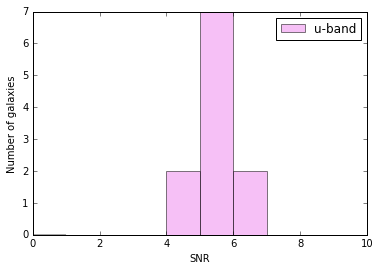

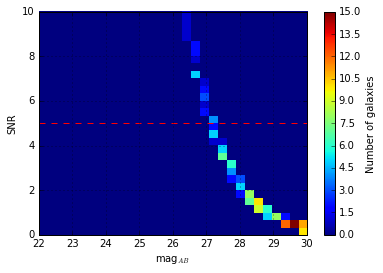

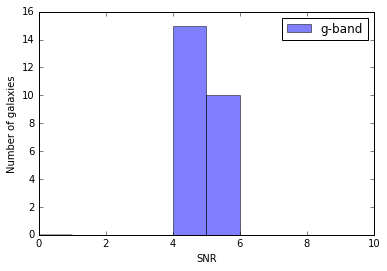

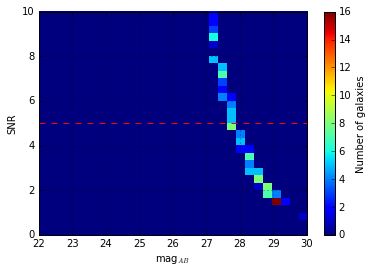

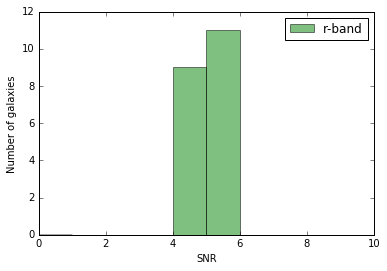

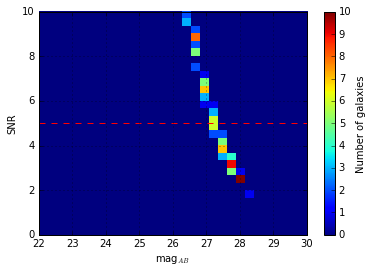

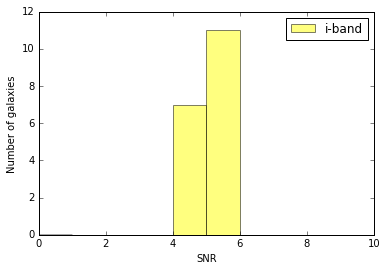

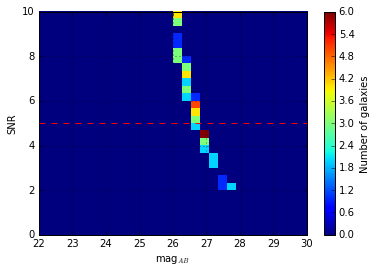

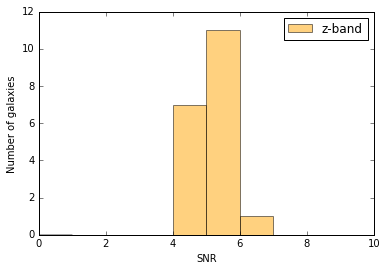

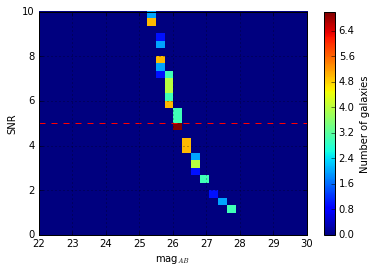

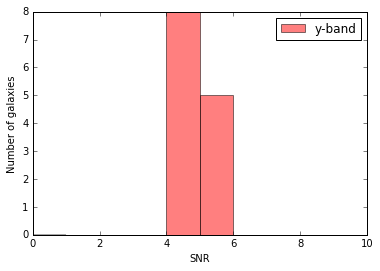

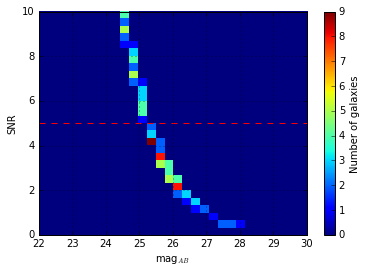

In [53]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, make_plot=False, make_plot2=True, mode='Ivezic', exptime=6900, X=1.2)

Band:  u median 5-sigma depth =  27.04 +- 0.16  Fiducial value = 26.89
Band:  u max 5-sigma depth=  27.1085
Band:  g median 5-sigma depth =  27.84 +- 0.16  Fiducial value = 27.74
Band:  g max 5-sigma depth=  27.8098
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value = 27.25
Band:  r max 5-sigma depth=  27.2179
Band:  i median 5-sigma depth =  26.72 +- 0.16  Fiducial value = 26.77
Band:  i max 5-sigma depth=  26.742
Band:  z median 5-sigma depth =  26.08 +- 0.16  Fiducial value = 26.20
Band:  z max 5-sigma depth=  26.0962
Band:  y median 5-sigma depth =  25.28 +- 0.16  Fiducial value = 25.26
Band:  y max 5-sigma depth=  25.1892


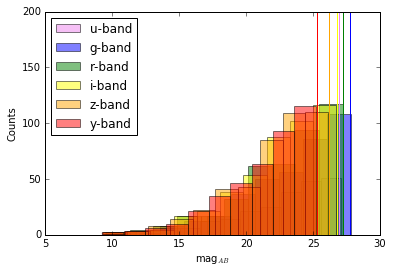

In [54]:
for band in ['u','g','r','i','z','y']:
    calculate_depth(band, make_plot=True,make_plot3=False,mode='Sys_eng', exptime=6900, X=1.2)

In [37]:
def calculate_depth_gal(band,make_plot=False, exptime=6900., X=1.2, mode='Ivezic', snr_name='snr_iso', make_plot2=False, make_plot3=True):
    #Values from Ivezic 2014
    if mode=='Ivezic':
        msky = {'u':22.9, 'g':22.3, 'r':21.2, 'i':20.5, 'z':19.6, 'y':18.6}
        cm = {'u':22.92 , 'g':24.29, 'r':24.33, 'i':24.20, 'z':24.07, 'y':23.69} 
        psf = {'u':0.77 , 'g':0.73, 'r':0.70, 'i':0.67, 'z':0.65, 'y':0.63} 
        inst_noise_corr = {'u':0.67 , 'g':0.21, 'r':0.11, 'i':0.08, 'z':0.05, 'y':0.04}
        km = {'u':0.451,'g':0.163,'r':0.087,'i':0.065,'z':0.043,'y':0.138}
    ####################
    #Values from https://github.com/lsst-pst/syseng_throughputs/blob/master/plots/table2
    if mode=='Sys_eng':
        psf = {'u':0.92 , 'g':0.87, 'r':0.83, 'i':0.80, 'z':0.78, 'y':0.76} 
        cm = {'u':22.74, 'g':24.38, 'r':24.43, 'i':24.30 , 'z':24.15, 'y':23.70}
        msky = {'u':22.95, 'g':22.24, 'r':21.20, 'i':20.47, 'z':19.60, 'y':18.63}
        inst_noise_corr = {'u':0.75 , 'g':0.19, 'r':0.10, 'i':0.07, 'z':0.05, 'y':0.04}
        km = {'u':0.5041,'g':0.2097,'r':0.1263,'i':0.0962,'z':0.0685,'y':0.1760}
    
    exptime_corr = {'u':0.,'g':0.,'r':0,'i':0,'z':0,'y':0} #This is going to be the electronic noise correction placeholder
    exptime_corr[band] = inst_noise_corr[band]-1.25*np.log10(1+(10**(0.8*inst_noise_corr[band])-1)/(exptime/30.))
    fid_depth = cm[band]+0.5*(msky[band]-21.)+2.5*np.log10(0.7/(psf[band]*X**0.6))-km[band]*(X-1)+1.25*np.log10(exptime/30.)+exptime_corr[band]
    colors = {'u':'violet','g':'blue','r':'green','i':'yellow','z':'orange','y':'red'}
    source_table = astropy.table.Table.read('./WeakLensingDeblending/LSST_%s_512_512.fits' %(band))
    if make_plot:
        plt.hist(source_table['ab_mag'][source_table[snr_name]>5.],alpha=0.5,label='%s-band' %band, color=colors[band])
        plt.plot(fid_depth*np.ones_like(np.arange(0,250,50)),np.arange(0,250,50),color=colors[band])
        plt.xlabel('mag$_{AB}$')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        #plt.xlim(17,28.5)
    maxdepth = np.nanmax(source_table['ab_mag'][source_table[snr_name]>=5.])
    mediandepth = np.nanmedian(source_table['ab_mag'][source_table[snr_name]>=5.])
    meandepth = np.nanmean(source_table['ab_mag'][source_table[snr_name]>=5.])
    mad = np.nanmedian(np.fabs(source_table['ab_mag'][source_table[snr_name]>=5.]-mediandepth))
    median_snr, bin_edges, binnumber = binned_statistic(source_table['ab_mag'],source_table['snr_iso'],statistic='median',bins=50,range=[(22,30)])
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    mask = np.isnan(median_snr)==False
    median_snr = median_snr[mask]
    bin_centers = bin_centers[mask]
    depth = bin_centers[np.argmin(np.fabs(median_snr-5))]
    delta_depth = bin_centers[1]-bin_centers[0]
    print 'Band: ',band, 'median 5-sigma depth = ', depth, '+-', delta_depth, ' Fiducial value = ', fid_depth
    print 'Band: ',band, '5-sigma limit = ',maxdepth
    if make_plot2:
        plt.figure()
        mask2 = np.logical_and(source_table['ab_mag']>=depth-delta_depth,source_table['ab_mag']<=depth+delta_depth)
        plt.hist(source_table['snr_iso'][mask2],range=(0,10),color=colors[band],label='%s-band' %band, alpha=0.5)
        plt.xlabel('SNR')
        plt.ylabel('Number of galaxies')
        plt.legend(loc='best')
    if make_plot3:
        plt.figure()
        plt.hist2d(source_table['ab_mag'],source_table['snr_iso'],range=[(22,30),(0,10)],bins=30)
        plt.plot(np.linspace(22,30,5),5*np.ones(5),'r--')
        plt.xlabel('mag$_{AB}$')
        plt.ylabel('SNR')
        plt.colorbar(label='Number of galaxies')
        plt.grid()
    return maxdepth, mediandepth

Band:  u median 5-sigma depth =  27.04 +- 0.16  Fiducial value =  27.1313961924
Band:  u 5-sigma limit =  27.0494
Band:  g median 5-sigma depth =  27.68 +- 0.16  Fiducial value =  27.9819504327
Band:  g 5-sigma limit =  27.7733
Band:  r median 5-sigma depth =  27.04 +- 0.16  Fiducial value =  27.490244339
Band:  r 5-sigma limit =  27.174
Band:  i median 5-sigma depth =  26.56 +- 0.16  Fiducial value =  27.0113870527
Band:  i 5-sigma limit =  26.7051
Band:  z median 5-sigma depth =  25.92 +- 0.16  Fiducial value =  26.439512588
Band:  z 5-sigma limit =  26.0908
Band:  y median 5-sigma depth =  24.96 +- 0.16  Fiducial value =  25.5012623329
Band:  y 5-sigma limit =  25.1817


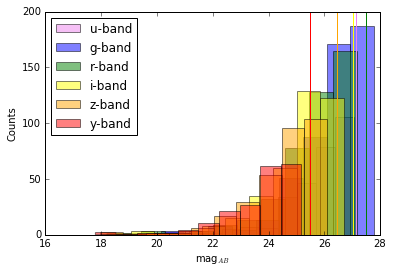

In [38]:
for band in ['u','g','r','i','z','y']:
    calculate_depth_gal(band, make_plot=True, make_plot3=False, make_plot2=False, mode='Sys_eng', exptime=6900, X=1.2)

In [16]:
hdulist = fits.open('./WeakLensingDeblending/LSST_r_512_512.fits')

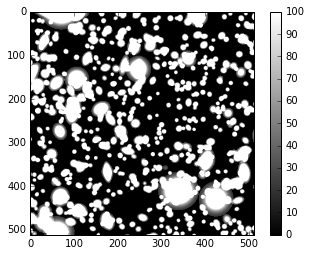

In [20]:
plt.imshow(hdulist[0].data,cmap='gray',vmax=100)
plt.colorbar()

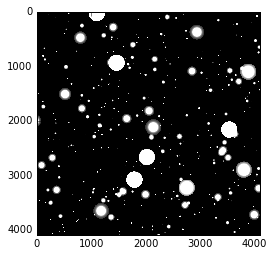

In [26]:
hdulist = fits.open('./WeakLensingDeblending/LSST_r_stars_4096_4096.fits')
plt.imshow(hdulist[0].data[0:4096,0:4096],cmap='gray',vmax=100)

In [56]:
def calculate_depth_airmass(band,filename,make_plot=False, exptime=6900., X=1.2, mode='Ivezic', snr_name='snr_iso', make_plot2=False, make_plot3=True):
    #Values from Ivezic 2014
    if mode=='Ivezic':
        msky = {'u':22.9, 'g':22.3, 'r':21.2, 'i':20.5, 'z':19.6, 'y':18.6}
        cm = {'u':22.92 , 'g':24.29, 'r':24.33, 'i':24.20, 'z':24.07, 'y':23.69} 
        psf = {'u':0.77 , 'g':0.73, 'r':0.70, 'i':0.67, 'z':0.65, 'y':0.63} 
        inst_noise_corr = {'u':0.67 , 'g':0.21, 'r':0.11, 'i':0.08, 'z':0.05, 'y':0.04}
        km = {'u':0.451,'g':0.163,'r':0.087,'i':0.065,'z':0.043,'y':0.138}
    ####################
    #Values from https://github.com/lsst-pst/syseng_throughputs/blob/master/plots/table2
    if mode=='Sys_eng':
        psf = {'u':0.92 , 'g':0.87, 'r':0.83, 'i':0.80, 'z':0.78, 'y':0.76} 
        cm = {'u':22.74, 'g':24.38, 'r':24.43, 'i':24.30 , 'z':24.15, 'y':23.70}
        msky = {'u':22.95, 'g':22.24, 'r':21.20, 'i':20.47, 'z':19.60, 'y':18.63}
        inst_noise_corr = {'u':0.75 , 'g':0.19, 'r':0.10, 'i':0.07, 'z':0.05, 'y':0.04}
        km = {'u':0.5041,'g':0.2097,'r':0.1263,'i':0.0962,'z':0.0685,'y':0.1760}
    
    exptime_corr = {'u':0.,'g':0.,'r':0,'i':0,'z':0,'y':0} #This is going to be the electronic noise correction placeholder
    exptime_corr[band] = inst_noise_corr[band]-1.25*np.log10(1+(10**(0.8*inst_noise_corr[band])-1)/(exptime/30.))
    fid_depth = cm[band]+0.5*(msky[band]-21.)+2.5*np.log10(0.7/(psf[band]*X**0.6))-km[band]*(X-1)+1.25*np.log10(exptime/30.)+exptime_corr[band]
    colors = {'u':'violet','g':'blue','r':'green','i':'yellow','z':'orange','y':'red'}
    source_table = astropy.table.Table.read(filename)
    if make_plot:
        plt.hist(source_table['ab_mag'][source_table[snr_name]>5.],alpha=0.5,label='%s-band' %band, color=colors[band])
        plt.plot(fid_depth*np.ones_like(np.arange(0,250,50)),np.arange(0,250,50),color=colors[band])
        plt.xlabel('mag$_{AB}$')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        #plt.xlim(17,28.5)
    maxdepth = np.nanmax(source_table['ab_mag'][source_table[snr_name]>=5.])
    mediandepth = np.nanmedian(source_table['ab_mag'][source_table[snr_name]>=5.])
    meandepth = np.nanmean(source_table['ab_mag'][source_table[snr_name]>=5.])
    mad = np.nanmedian(np.fabs(source_table['ab_mag'][source_table[snr_name]>=5.]-mediandepth))
    median_snr, bin_edges, binnumber = binned_statistic(source_table['ab_mag'],source_table['snr_iso'],statistic='median',bins=50,range=[(22,30)])
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    mask = np.isnan(median_snr)==False
    median_snr = median_snr[mask]
    bin_centers = bin_centers[mask]
    depth = bin_centers[np.argmin(np.fabs(median_snr-5))]
    delta_depth = bin_centers[4]-bin_centers[3]
    print 'Band: ',band, 'median 5-sigma depth = ', depth, '+-', delta_depth, ' Fiducial value = %.2f' % fid_depth
    print 'Band: ',band, 'max 5-sigma depth= ', maxdepth
    if make_plot2:
        plt.figure()
        mask2 = np.logical_and(source_table['ab_mag']>=depth-delta_depth,source_table['ab_mag']<=depth+delta_depth)
        plt.hist(source_table['snr_iso'][mask2],range=(0,10),color=colors[band],label='%s-band' %band, alpha=0.5)
        plt.xlabel('SNR')
        plt.ylabel('Number of galaxies')
        plt.legend(loc='best')
    if make_plot3:
        plt.figure()
        plt.hist2d(source_table['ab_mag'],source_table['snr_iso'],range=[(22,30),(0,10)],bins=30)
        plt.plot(np.linspace(22,30,5),5*np.ones(5),'r--')
        plt.xlabel('mag$_{AB}$')
        plt.ylabel('SNR')
        plt.colorbar(label='Number of galaxies')
        plt.grid()
    return maxdepth, depth, fid_depth

In [42]:
import glob

Band:  r median 5-sigma depth =  27.36 +- 0.16  Fiducial value = 27.40
Band:  r max 5-sigma depth=  27.3309
27.36
Band:  r median 5-sigma depth =  27.2 +- 0.16  Fiducial value = 27.25
Band:  r max 5-sigma depth=  27.2179
27.2
Band:  r median 5-sigma depth =  27.04 +- 0.16  Fiducial value = 27.13
Band:  r max 5-sigma depth=  27.0897
27.04
Band:  r median 5-sigma depth =  27.04 +- 0.16  Fiducial value = 27.01
Band:  r max 5-sigma depth=  27.0065
27.04
Band:  r median 5-sigma depth =  26.88 +- 0.16  Fiducial value = 26.82
Band:  r max 5-sigma depth=  26.8275
26.88
Band:  r median 5-sigma depth =  26.72 +- 0.16  Fiducial value = 26.61
Band:  r max 5-sigma depth=  26.69
26.72


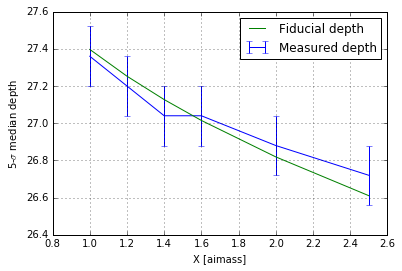

In [58]:
filelist = glob.glob('./WeakLensingDeblending/LSST_stars_r_4096_4096_X_*.fits')
airmass_values = np.array([1.0,1.2,1.4,1.6,2.0,2.5])
max_depth = np.zeros(len(filelist))
median_depth = np.zeros(len(filelist))
fid_depth = np.zeros(len(filelist))
for i,filename in enumerate(filelist):
    max_depth[i],median_depth[i], fid_depth[i] = calculate_depth_airmass('r',filename,X=airmass_values[i], mode='Sys_eng',make_plot3=False)
    print median_depth[i]
plt.errorbar(airmass_values,median_depth,0.16*np.ones(len(filelist)),label='Measured depth')
plt.plot(airmass_values,fid_depth,label='Fiducial depth')
plt.xlabel('X [aimass]')
plt.ylabel('5-$\sigma$ median depth')
plt.legend(loc='best')
plt.grid()